In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.dpi'] = 200

In [2]:
data_path = '../data/CALC_STRAIGHT_CLEAN/'
files = [f for f in os.listdir(data_path) if f.endswith('.csv')]

In [3]:
print('STRAIGHT SEGMENTS:\t'+ str(len(files)))

STRAIGHT SEGMENTS:	311


In [4]:
A = pd.read_csv('../data/STRAIGHT_STEP_FREQ_CLEAN.csv')
A.head()

,File,IndexStart,IndexEnd,StepsL,StepsR,Ts,SegLen,TimeLen,StepFreqL,StepFreqR,CadL,CadR,MaxDir,MinDir,MeanDir,StdDir,Type
0,N-01-1-Char00part2seg-9_sub_0.csv,58127.0,59961.0,12.0,13.0,0.008,1835.0,14.680,0.817439,0.885559,1.223333,1.129231,-65.195771,-134.512166,-80.112084,6.818842,N
1,A-615829-Char00part1seg-4_sub_1.csv,37215.0,37836.0,3.0,2.0,0.008,622.0,4.976,0.602894,0.401929,1.658667,2.488000,151.185526,17.011236,90.361148,31.200162,A
2,N-25031996-Char00part3seg-2_sub_0.csv,24585.0,26738.0,14.0,14.0,0.008,2154.0,17.232,0.812442,0.812442,1.230857,1.230857,115.613353,-117.315695,-74.752300,12.243346,N
3,A-766012-Char00part1seg-1_sub_5.csv,5114.0,6533.0,11.0,10.0,0.017,1420.0,24.140,0.455675,0.414250,2.194545,2.414000,31.103251,-71.406641,-20.846895,20.233188,A
4,N-740516-Char00part3seg-0_sub_0.csv,7316.0,8149.0,13.0,12.0,0.017,834.0,14.178,0.916914,0.846382,1.090615,1.181500,-35.739444,-136.718920,-108.459980,16.910178,N


In [5]:
text_file = open('../data/JointNamesCalc.txt', "r")
joint_names_calc = text_file.read().split('\n')
len(joint_names_calc)

61

In [6]:
spine_joints = ['Spine3','Spine2','Spine1','Spine','Hips']
spine_joints_ind = np.zeros([len(spine_joints),1])
cc = 0
for c in spine_joints:
    spine_joints_ind[cc] = joint_names_calc.index(c) + 1
    cc+=1
spine_joints_ind

array([[18.],
       [19.],
       [20.],
       [21.],
       [ 1.]])

In [7]:
def mean_xyz(df):
    avg = pd.DataFrame()
    for dim in ['x','y','z']:
        dim_cols = [s for s in df.columns.to_list() if dim in s]
        dim_df = df.filter(dim_cols,axis=1)
        avg[dim] = np.mean(dim_df,axis=1)
    return avg

In [8]:
def planes(COM,Lshoulder,Rshoulder,MidShoulder):
    # These two vectors are in the plane
    v1 = Lshoulder - COM
    v2 = Rshoulder - COM

    # the cross product is a vector normal to the plane
    normal_coronal = np.cross(v1, v2)
    a_c, b_c, c_c = normal_coronal

    d_c = np.dot(normal_coronal, COM)
    coronal = a_c, b_c, c_c, d_c
    
    v3 = MidShoulder - COM
    
    normal_sagittal = np.cross(normal_coronal, v3)
    a_s, b_s, c_s = normal_sagittal
    
    d_s = np.dot(normal_sagittal, COM)
    sagittal = a_s, b_s, c_s, d_s
    
    normal_axial = np.cross(normal_coronal, normal_sagittal)
    a_a, b_a, c_a = normal_axial
    
    d_a = np.dot(normal_axial, COM)    
    axial = a_a, b_a, c_a, d_a
    return coronal, sagittal, axial


In [9]:
def projection(point,plane):
    x1, y1, z1 = point
    a, b, c, d = plane
    t = (-a * x1 - b * y1 - c * z1 - d) / (a * a + b * b + c * c);  
    x2 = a * t + x1;  
    y2 = b * t + y1;  
    z2 = c * t + z1; 
    proj = x2, y2, z2
    return proj

In [10]:
for file in tqdm(files):
    df = pd.read_csv(data_path + file)
    position_cols = [s for s in df.columns.to_list() if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    # DROP ZERO COLUMNS
    xxdf = xdf.replace(0, np.nan)
    xxdf = xxdf.dropna(how='all', axis=1)
    xdf = xxdf.replace(np.nan, 0)

    '''
    # Subtract mean from all positions
    mdf = pd.DataFrame()
    for dim in ['x','y','z']:
        dim_cols = [s for s in xdf.columns.to_list() if dim in s]
        dim_df = xdf.filter(dim_cols,axis=1)
        for col in dim_df.columns:
            mdf[col] = dim_df[col] - mean_xyz(xdf)[dim]       
    xdf = mdf
    '''

    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
    N = np.size(df,axis=0)
        
    # COM
    COM_cols_ind = []
    for c in spine_joints_ind:
        for col in xdf.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    COM_cols_ind.append(xdf.columns.to_list().index(col))

    COM_df = xdf.filter(xdf.columns[COM_cols_ind],axis=1)
    COM = mean_xyz(COM_df)
    
    # Hip center
    HC_cols = []
    for col in xdf.columns.to_list():
        if ('0'+str(int(1))) in col:
            HC_cols.append(xdf.columns.to_list().index(col))
    HC_df = xdf.filter(xdf.columns[HC_cols],axis=1)
    
    # Left Shoulder
    LS_cols = []
    for col in xdf.columns.to_list():
        if (str(int(12))) in col:
            LS_cols.append(xdf.columns.to_list().index(col))
    LS_df = xdf.filter(xdf.columns[LS_cols],axis=1)
    
    # Right Shoulder
    RS_cols = []
    for col in xdf.columns.to_list():
        if ('0'+str(int(8))) in col:
            RS_cols.append(xdf.columns.to_list().index(col))
    RS_df = xdf.filter(xdf.columns[RS_cols],axis=1)
    
    # Mid Shoulder
    MS_cols = []
    for col in xdf.columns.to_list():
        if (str(int(18))) in col:
            MS_cols.append(xdf.columns.to_list().index(col))
    MS_df = xdf.filter(xdf.columns[MS_cols],axis=1)
    
    # PLANES, all going through hip center, need 3 points | 2 point and 1 vector |1 point and 2 vectors
    # coronal = frontal: hip center + shoulders (joint 8,12)
    # sagittal = side:   hip center + center between shoulders (joint 18) + normal vector from coronal plane
    # axial = top        hip center + two normal vectors from coronal and sagittal plane
    
    c_proj = np.zeros((N,3))
    s_proj = np.zeros((N,3))
    a_proj = np.zeros((N,3))
    for i in range(0,N):
        c,s,a = planes(HC_df.iloc[i,:].values,LS_df.iloc[i,:].values,RS_df.iloc[i,:].values,MS_df.iloc[i,:].values)
        c_proj[i,:] = projection(COM.iloc[i,:].values,c)
        s_proj[i,:] = projection(COM.iloc[i,:].values,s)
        a_proj[i,:] = projection(COM.iloc[i,:].values,a)
        
        # TODO
        #-SD of COM in projection
    break

  0%|          | 0/311 [00:00<?, ?it/s]


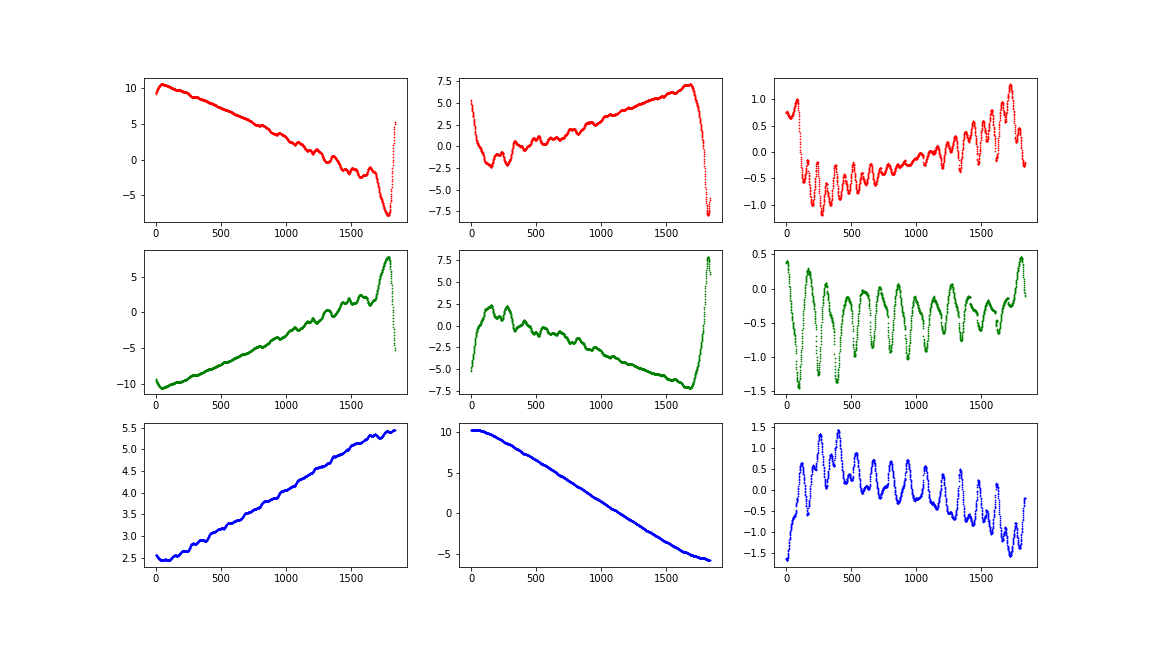

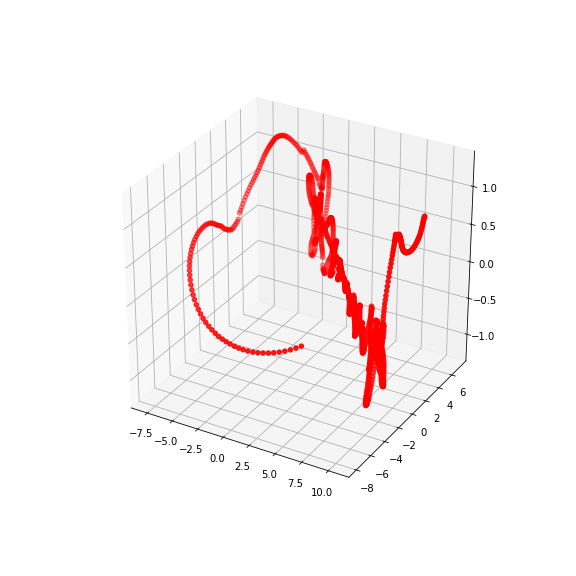

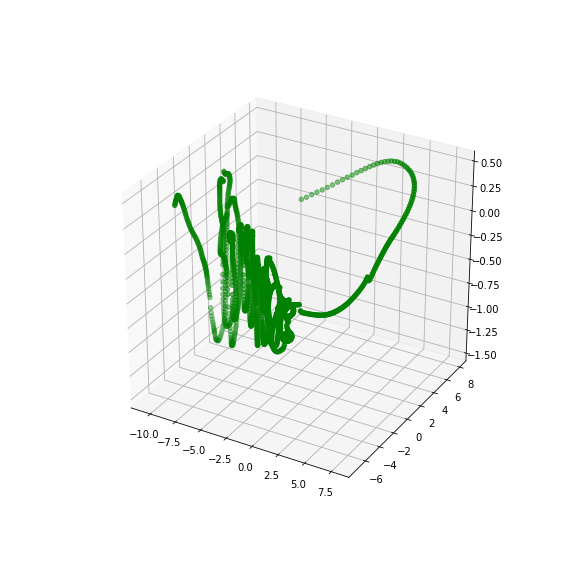

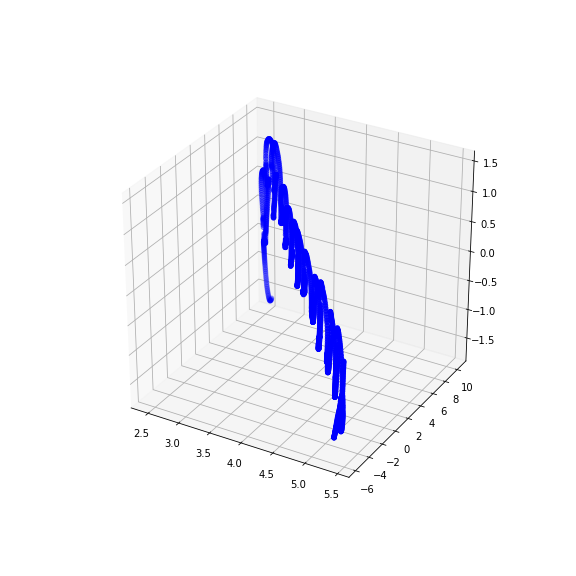

In [11]:
fig,ax = plt.subplots(3,3,figsize=(16,9))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
fig31 = plt.figure(figsize=(8,8))
fig32 = plt.figure(figsize=(8,8))
fig33 = plt.figure(figsize=(8,8))
ax31 = fig31.add_subplot(111, projection='3d')
ax32 = fig32.add_subplot(111, projection='3d')
ax33 = fig33.add_subplot(111, projection='3d')

#for i in np.arange(0,N):
i = np.arange(0,N)
ax[0,0].scatter(i,c_proj[i,0], c='r',s=0.5)
ax[0,1].scatter(i,c_proj[i,1], c='r',s=0.5)
ax[0,2].scatter(i,c_proj[i,2], c='r',s=0.5)

ax[1,0].scatter(i,s_proj[i,0], c='g',s=0.5)
ax[1,1].scatter(i,s_proj[i,1], c='g',s=0.5)
ax[1,2].scatter(i,s_proj[i,2], c='g',s=0.5)

ax[2,0].scatter(i,a_proj[i,0], c='b',s=0.5)
ax[2,1].scatter(i,a_proj[i,1], c='b',s=0.5)
ax[2,2].scatter(i,a_proj[i,2], c='b',s=0.5)

ax31.scatter(c_proj[i,0], c_proj[i,1], c_proj[i,2], c='r')
ax32.scatter(s_proj[i,0], s_proj[i,1], s_proj[i,2], c='g')
ax33.scatter(a_proj[i,0], a_proj[i,1], a_proj[i,2], c='b')
#plt.show()
    

# Second version with one normal vector from COM movement

In [58]:
def planes2(COM,Lshoulder,Rshoulder,MidShoulder,VEC):

    # normal vector to the coronal plane
    normal_coronal = VEC
    a_c, b_c, c_c = normal_coronal

    d_c = np.dot(normal_coronal, COM)
    coronal = a_c, b_c, c_c, d_c
    
    v3 = MidShoulder - COM
    
    normal_sagittal = np.cross(normal_coronal, v3)
    a_s, b_s, c_s = normal_sagittal
    
    d_s = np.dot(normal_sagittal, COM)
    sagittal = a_s, b_s, c_s, d_s
    
    normal_axial = np.cross(normal_coronal, normal_sagittal)
    a_a, b_a, c_a = normal_axial
    
    d_a = np.dot(normal_axial, COM)    
    axial = a_a, b_a, c_a, d_a
    return coronal, sagittal, axial


In [59]:
for file in tqdm(files):
    df = pd.read_csv(data_path + file)
    position_cols = [s for s in df.columns.to_list() if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    # DROP ZERO COLUMNS
    xxdf = xdf.replace(0, np.nan)
    xxdf = xxdf.dropna(how='all', axis=1)
    xdf = xxdf.replace(np.nan, 0)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
    N = np.size(df,axis=0)
    
    # COM
    COM_cols_ind = []
    for c in spine_joints_ind:
        for col in xdf.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    COM_cols_ind.append(xdf.columns.to_list().index(col))

    COM_df = xdf.filter(xdf.columns[COM_cols_ind],axis=1)
    COM = mean_xyz(COM_df)
    
    # Hip center
    HC_cols = []
    for col in xdf.columns.to_list():
        if ('0'+str(int(1))) in col:
            HC_cols.append(xdf.columns.to_list().index(col))
    HC_df = xdf.filter(xdf.columns[HC_cols],axis=1)
    
    # Left Shoulder
    LS_cols = []
    for col in xdf.columns.to_list():
        if (str(int(12))) in col:
            LS_cols.append(xdf.columns.to_list().index(col))
    LS_df = xdf.filter(xdf.columns[LS_cols],axis=1)
    
    # Right Shoulder
    RS_cols = []
    for col in xdf.columns.to_list():
        if ('0'+str(int(8))) in col:
            RS_cols.append(xdf.columns.to_list().index(col))
    RS_df = xdf.filter(xdf.columns[RS_cols],axis=1)
    
    # Mid Shoulder
    MS_cols = []
    for col in xdf.columns.to_list():
        if (str(int(18))) in col:
            MS_cols.append(xdf.columns.to_list().index(col))
    MS_df = xdf.filter(xdf.columns[MS_cols],axis=1)
    
    # PLANES, all going through hip center, need 3 points | 2 point and 1 vector |1 point and 2 vectors
    
    # coronal = frontal: hip center + main movement vector
    # sagittal = side:   hip center + center between shoulders (joint 18) + normal vector from coronal plane
    # axial = top        hip center + two normal vectors from coronal and sagittal plane
    
    # MOVEMENT VECTOR
    # One vector from regression of COM movement in this segment
    X = COM[['x', 'y', 'z']].values
    Xlen = X.shape[0]
    avgPointCloud = 1 / Xlen * np.array([np.sum(X[:, 0]), np.sum(X[:, 1]), np.sum(X[:, 2])])
    Xmean = X - avgPointCloud
    cov = 1 / Xlen * X.T.dot(Xmean)
    t = np.arange(-5, 5, 1)
    linearReg = avgPointCloud + cov[:, 0] * np.vstack(t)
    
    VEC = linearReg[-1,:]-linearReg[0,:]
    
    # STEPS INDEX
    #peaksL = np.where(np.diff(df.contactL_clean)>0)[0]
    #peaksR = np.where(np.diff(df.contactR_clean)>0)[0]
    
    #if len(peaksL) > len(peaksR):
    #    steps = peaksL
    #else:
    #    steps = peaksR
    
    # EXCLUDE FIRST AND LAST STEP
    #steps = steps[1:-1]
    
    # EVEN NUMBER OF STEPS - cut the last one
    #if len(steps)%2==1:
    #    steps = steps[:-1]
    
    c_proj = np.zeros((N,3))
    s_proj = np.zeros((N,3))
    a_proj = np.zeros((N,3))
    
    for i in range(0,N):
        c,s,a = planes2(HC_df.iloc[i,:].values,LS_df.iloc[i,:].values,RS_df.iloc[i,:].values,MS_df.iloc[i,:].values,VEC)
        c_proj[i,:] = projection(COM.iloc[i,:].values,c)
        s_proj[i,:] = projection(COM.iloc[i,:].values,s)
        a_proj[i,:] = projection(COM.iloc[i,:].values,a)
        
    # SD of COM in projection
    
    break

  0%|          | 0/311 [00:00<?, ?it/s]


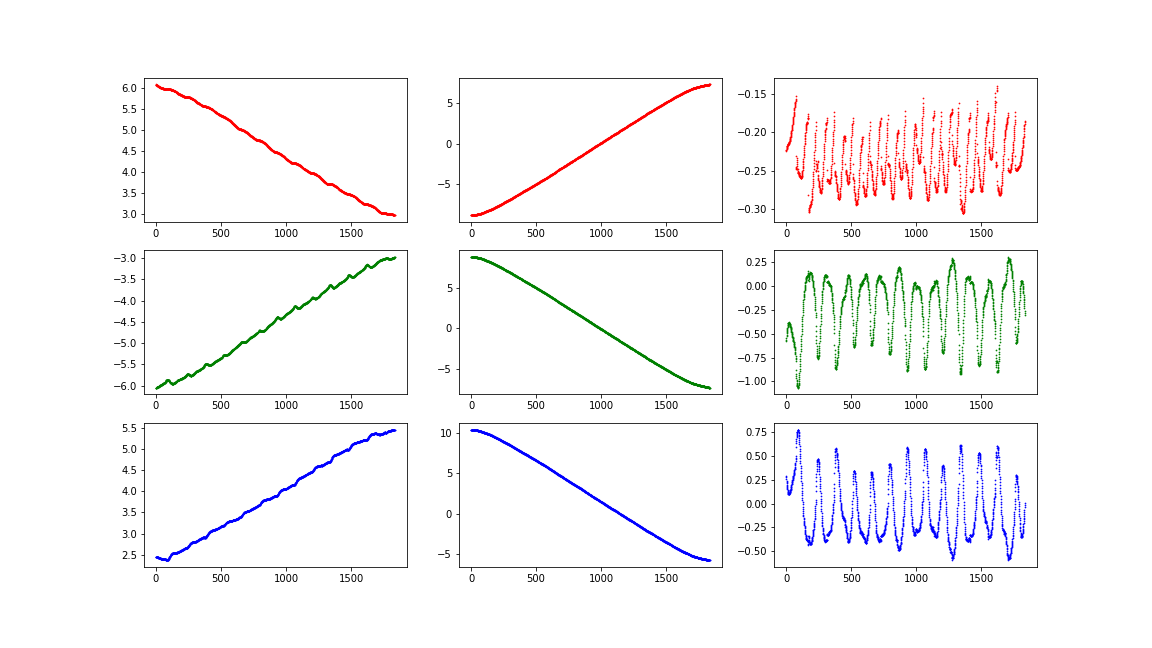

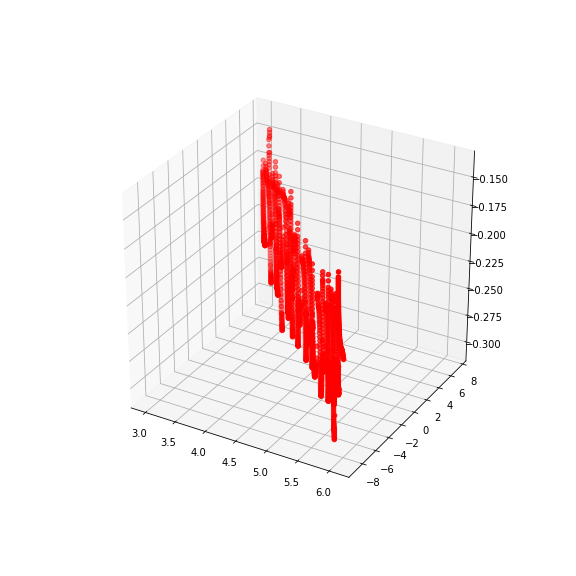

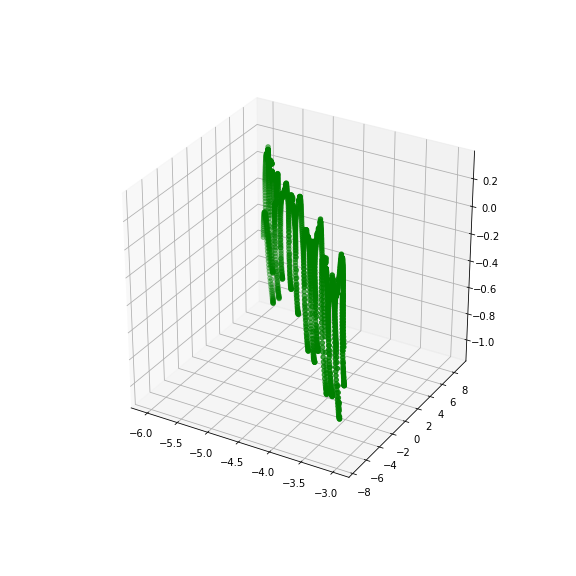

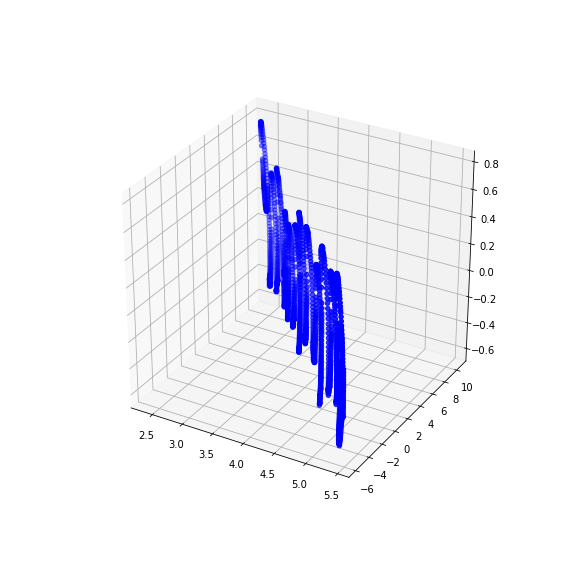

In [60]:
fig,ax = plt.subplots(3,3,figsize=(16,9))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
fig31 = plt.figure(figsize=(8,8))
fig32 = plt.figure(figsize=(8,8))
fig33 = plt.figure(figsize=(8,8))
ax31 = fig31.add_subplot(111, projection='3d')
ax32 = fig32.add_subplot(111, projection='3d')
ax33 = fig33.add_subplot(111, projection='3d')

#for i in np.arange(0,N):
i = np.arange(0,N)
ax[0,0].scatter(i,c_proj[i,0], c='r',s=0.5)
ax[0,1].scatter(i,c_proj[i,1], c='r',s=0.5)
ax[0,2].scatter(i,c_proj[i,2], c='r',s=0.5)

ax[1,0].scatter(i,s_proj[i,0], c='g',s=0.5)
ax[1,1].scatter(i,s_proj[i,1], c='g',s=0.5)
ax[1,2].scatter(i,s_proj[i,2], c='g',s=0.5)

ax[2,0].scatter(i,a_proj[i,0], c='b',s=0.5)
ax[2,1].scatter(i,a_proj[i,1], c='b',s=0.5)
ax[2,2].scatter(i,a_proj[i,2], c='b',s=0.5)

ax31.scatter(c_proj[i,0], c_proj[i,1], c_proj[i,2], c='r')
ax32.scatter(s_proj[i,0], s_proj[i,1], s_proj[i,2], c='g')
ax33.scatter(a_proj[i,0], a_proj[i,1], a_proj[i,2], c='b')
#plt.show()
    

### ONE PLANE

In [52]:
for file in tqdm(files):
    df = pd.read_csv(data_path + file)
    position_cols = [s for s in df.columns.to_list() if "X" in s]
    xdf = df.filter(position_cols,axis=1)
    
    # DROP ZERO COLUMNS
    xxdf = xdf.replace(0, np.nan)
    xxdf = xxdf.dropna(how='all', axis=1)
    xdf = xxdf.replace(np.nan, 0)
    
    T_sampling = A.loc[A['File'] == file,'Ts'].values
    N = np.size(df,axis=0)
    
    # COM
    COM_cols_ind = []
    for c in spine_joints_ind:
        for col in xdf.columns.to_list():
                if c<10:
                    name = '0' + str(int(c)) + '-'
                else:
                    name = str(int(c)) + '-'
                if col.startswith(name):
                    COM_cols_ind.append(xdf.columns.to_list().index(col))

    COM_df = xdf.filter(xdf.columns[COM_cols_ind],axis=1)
    COM = mean_xyz(COM_df)
    
    # Hip center
    HC_cols = []
    for col in xdf.columns.to_list():
        if ('0'+str(int(1))) in col:
            HC_cols.append(xdf.columns.to_list().index(col))
    HC_df = xdf.filter(xdf.columns[HC_cols],axis=1)
    
    # 3 PLANES
    
    # coronal = frontal: hip center + main movement vector
    # sagittal = side:   hip center + center between shoulders (joint 18) + normal vector from coronal plane
    # axial = top        hip center + two normal vectors from coronal and sagittal plane
    
    # MOVEMENT VECTOR
    # One vector from regression of COM movement in this segment
    X = COM[['x', 'y', 'z']].values
    Xlen = X.shape[0]
    avgPointCloud = 1 / Xlen * np.array([np.sum(X[:, 0]), np.sum(X[:, 1]), np.sum(X[:, 2])])
    Xmean = X - avgPointCloud
    cov = 1 / Xlen * X.T.dot(Xmean)
    t = np.arange(-5, 5, 1)
    linearReg = avgPointCloud + cov[:, 0] * np.vstack(t)
    
    # normal vectors
    normal_coronal = linearReg[-1,:]-linearReg[0,:]

    # X[0,:] - HIP CENTER LOCATION FOR FIRST FRAME
    common_point = COM.iloc[0,:].values
    
    a_c, b_c, c_c = normal_coronal
    d_c = np.dot(normal_coronal,common_point)
    coronal = a_c, b_c, c_c, d_c
    
    c_proj = np.zeros((N,3))
    
    for i in range(0,N):
        c_proj[i,:] = projection(COM.iloc[i,:].values,coronal)
        
    # SD of COM in projection
    
    break

  0%|          | 0/311 [00:00<?, ?it/s]


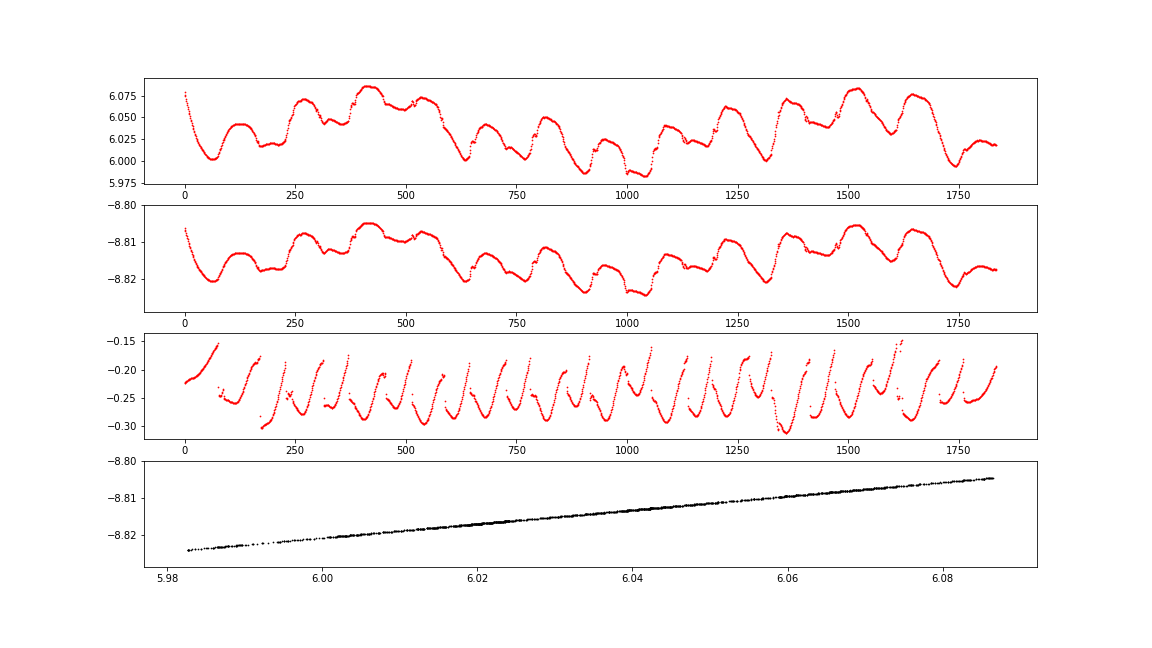

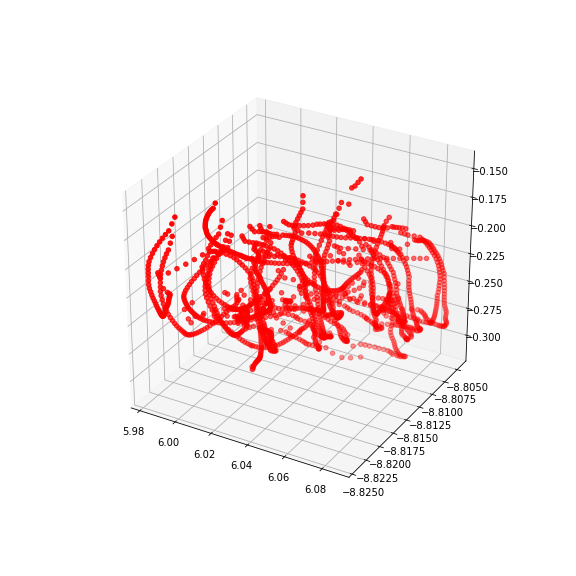

In [57]:
fig,ax = plt.subplots(4,1,figsize=(16,9))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
fig31 = plt.figure(figsize=(8,8))
ax31 = fig31.add_subplot(111, projection='3d')

#for i in np.arange(0,N):
i = np.arange(0,N)
ax[0].scatter(i,c_proj[i,0], c='r',s=0.5)
ax[1].scatter(i,c_proj[i,1], c='r',s=0.5)
ax[2].scatter(i,c_proj[i,2], c='r',s=0.5)
ax[3].scatter(c_proj[i,0],c_proj[i,1], c='k',s=0.5)

ax31.scatter(c_proj[i,0], c_proj[i,1], c_proj[i,2], c='r')

#plt.show()
    

In [43]:
import plotly.graph_objects as go
import plotly

In [51]:
fig = go.Figure(data=[go.Scatter3d(x=c_proj[:,0], y=c_proj[:,1], z=c_proj[:,2],
                                   marker=dict(
                                        size=2,
                                        color='green',
                                    ),
                                    line=dict(
                                        color='rgb(255,0,0)',
                                        width=1
                                    ))])
fig.show()

In [34]:
#fig = plt.figure(figsize=(8,8))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(COM.x.values,COM.y.values,COM.z.values)
#ax.view_init(elev=30, azim=30)
#ax.set_xlabel('x [m]')
#ax.set_ylabel('y [m]')
#ax.set_zlabel('z [m]')
#ax.set_title('COM movement')

# Linear regression
X = COM[['x', 'y', 'z']].values
Xlen = X.shape[0]
avgPointCloud = 1 / Xlen * np.array([np.sum(X[:, 0]), np.sum(X[:, 1]), np.sum(X[:, 2])])
Xmean = X - avgPointCloud

cov = 1 / Xlen * X.T.dot(Xmean)

t = [-2,2]
linearReg = avgPointCloud + cov[:, 0] * np.vstack(t)

#ax.plot(linearReg[:, 0], linearReg[:, 1], linearReg[:, 2], 'r', label='Linear Regression')
#ax.legend()
trace = go.Scatter3d(x=COM.x, y=COM.y, z=COM.z,
                                   marker=dict(
                                        size=2,
                                        color='green',
                                    ),
                                    line=dict(
                                        color='black',
                                        width=1
                                    ))
trace2 =go.Scatter3d(x=linearReg[:, 0], y=linearReg[:, 1], z=linearReg[:, 2],
                                    line=dict(
                                        color='red',
                                        width=5
                                    ))
fig = go.Figure(data=[trace,trace2])
fig.show()